In [1]:
import os
import pandas as pd
import sys
sys.path.append(os.path.abspath(os.path.join('..','iESPnet_SRC_main','utilities')))
from Generator import SeizureDatasetLabelTime, scale_spec, permute_spec, smoothing_label
from Model import iESPnet
from TrainEval import train_model_opt, test_model, train_model, get_thr_output, get_performance_indices
import IO
import Epochs
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import torchaudio.transforms as T
import numpy as np
import mne
mne.set_log_level(verbose='warning') #to avoid info at terminal
import matplotlib.pyplot as plt
import librosa
from scipy import fft as sp_fft
from matplotlib.backends.backend_pdf import PdfPages

# set the seed for reproducibility
torch.manual_seed(0)

In [2]:
meta_data_file = '/media/martin/Disco2/Rns_Data/PITT_PI_v2/METADATA_v2/allfiles_metadata.csv'
df_meta = pd.read_csv(meta_data_file)

In [3]:
# muestra la informacion del dataframe
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44223 entries, 0 to 44222
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rns_id  44223 non-null  object 
 1   data    44223 non-null  object 
 2   label   44223 non-null  int64  
 3   time    44223 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.3+ MB


In [4]:
# muestra los primeros 5 datos del dataframe 
df_meta.head()

,rns_id,data,label,time
0,PIT-RNS1603,PIT_RNS1603_20150804-1_E0,0,0.0
1,PIT-RNS1603,PIT_RNS1603_20150804-1_E1,0,0.0
2,PIT-RNS1603,PIT_RNS1603_20150804-1_E2,0,0.0
3,PIT-RNS1603,PIT_RNS1603_20150804-1_E3,0,0.0
4,PIT-RNS1603,PIT_RNS1603_20150804-1_E4,0,0.0


In [5]:
# muestra las columnas del dataframe, tambien pueden verse en el df.info()
df_meta.columns

Index(['rns_id', 'data', 'label', 'time'], dtype='object')

In [6]:
# muestra el tamaño del dataframe
df_meta.shape

(44223, 4)

In [7]:
# muestra el tipo de dato de df_meta
type(df_meta)

pandas.core.frame.DataFrame

In [8]:
# muestras los valores unicos 
df_meta['rns_id'].unique()

array(['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS3016', 'PIT-RNS1529',
       'PIT-RNS7168', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183',
       'PIT-RNS1440', 'PIT-RNS1713', 'PIT-RNS9536', 'PIT-RNS2543',
       'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS9793', 'PIT-RNS1703',
       'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS8326',
       'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS4998', 'PIT-RNS8973',
       'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS6762',
       'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS0427', 'PIT-RNS8076'],
      dtype=object)

In [9]:
# muestra la cantidad de pacientes
len(df_meta['rns_id'].unique())
print('La cantidad de pacientes es:', len(df_meta['rns_id'].unique()))

La cantidad de pacientes es: 32


In [10]:
# se quiere hacer una lista con los id de los pacientes una unica vez
patients = df_meta['rns_id'].unique().tolist()
print(patients,'\n')
print('Se tienen los registros de {} pacientes'.format(len(patients)))

['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS3016', 'PIT-RNS1529', 'PIT-RNS7168', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183', 'PIT-RNS1440', 'PIT-RNS1713', 'PIT-RNS9536', 'PIT-RNS2543', 'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS9793', 'PIT-RNS1703', 'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS8326', 'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS4998', 'PIT-RNS8973', 'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS6762', 'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS0427', 'PIT-RNS8076'] 

Se tienen los registros de 32 pacientes


In [13]:
df_meta['rns_id'].value_counts()

rns_id
PIT-RNS4098    3882
PIT-RNS1440    3077
PIT-RNS1597    2477
PIT-RNS1836    2477
PIT-RNS2368    2460
PIT-RNS1438    2147
PIT-RNS9536    1948
PIT-RNS2543    1839
PIT-RNS1603    1808
PIT-RNS4998    1628
PIT-RNS0427    1585
PIT-RNS6989    1569
PIT-RNS1090    1567
PIT-RNS8326    1512
PIT-RNS3016    1490
PIT-RNS1703    1471
PIT-RNS6806    1468
PIT-RNS1529    1255
PIT-RNS8973    1251
PIT-RNS2938    1103
PIT-RNS1534    1081
PIT-RNS6992     950
PIT-RNS8163     689
PIT-RNS1556     657
PIT-RNS8076     577
PIT-RNS7168     530
PIT-RNS2227     426
PIT-RNS9183     386
PIT-RNS7525     360
PIT-RNS6762     328
PIT-RNS1713     193
PIT-RNS9793      32
Name: count, dtype: int64

In [15]:
# a que se le asigno label=2 --> esto si lo saque en el entrenamiento
df_meta['label'].value_counts()

label
0    34681
1     9477
2       65
Name: count, dtype: int64

In [16]:
# se puede visualizar como el onset esta cercano a 0 segundos en estos casos
df_meta[df_meta['label']==2]

,rns_id,data,label,time
18130,PIT-RNS9536,PIT_RNS9536_20161215-1_E62,2,0.091463
19498,PIT-RNS2543,PIT_RNS2543_20200225-1_E71,2,0.114000
19499,PIT-RNS2543,PIT_RNS2543_20200225-1_E72,2,0.103000
19501,PIT-RNS2543,PIT_RNS2543_20200225-1_E74,2,0.089000
19502,PIT-RNS2543,PIT_RNS2543_20200225-1_E75,2,0.088000
...,...,...,...,...
27200,PIT-RNS1597,PIT_RNS1597_20161012-1_E371,2,0.101626
30976,PIT-RNS2227,PIT_RNS2227_20160811-1_E96,2,0.066683
31017,PIT-RNS2227,PIT_RNS2227_20161012-1_E8,2,0.077000
31079,PIT-RNS2227,PIT_RNS2227_20161012-1_E70,2,0.095203


In [17]:
# en este caso se visualiza que el onset esta en tiempos mayores a un segundo
df_meta[df_meta['label']==1]

,rns_id,data,label,time
95,PIT-RNS1603,PIT_RNS1603_20150909-1_E23,1,38.261325
119,PIT-RNS1603,PIT_RNS1603_20150909-1_E47,1,9.438130
159,PIT-RNS1603,PIT_RNS1603_20151021-1_E4,1,31.906845
170,PIT-RNS1603,PIT_RNS1603_20151021-1_E15,1,38.072439
178,PIT-RNS1603,PIT_RNS1603_20151021-1_E23,1,37.034439
...,...,...,...,...
44175,PIT-RNS8076,PIT_RNS8076_20160406-2_E24,1,21.743000
44176,PIT-RNS8076,PIT_RNS8076_20160406-2_E25,1,25.253000
44177,PIT-RNS8076,PIT_RNS8076_20160406-2_E26,1,24.033000
44178,PIT-RNS8076,PIT_RNS8076_20160406-2_E27,1,18.728000


In [18]:
# se hace un drop de los datos con label = 2
df_meta.drop(df_meta[df_meta['label'] == 2].index, inplace = True)
df_meta['label'].value_counts()

label
0    34681
1     9477
Name: count, dtype: int64

In [19]:
df_meta[(df_meta['rns_id']=='PIT-RNS1603') & (df_meta['label']== 1)].shape

(291, 4)

In [20]:
df_meta[df_meta['rns_id']=='PIT-RNS1603'].shape

(1808, 4)

Pacientes que estan implantados en el talamo

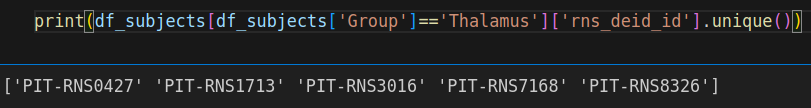

In [21]:
# direccion de donde se encuentran los espectrogramas
SPE_DIR  = '/media/martin/Disco2/Rns_Data/PITT_PI_v2/'

In [22]:
# separación de datos de entrenamiento y testeo

s=0 # es el paciente que se deja afuera para el entrenamiento

train_df = df_meta.copy()
test_df  = df_meta[df_meta['rns_id'] == patients[s]]
test_df.reset_index(drop=True, inplace=True)
train_df.drop(train_df[train_df['rns_id'] == patients[s]].index, inplace = True)

In [ ]:
# Hace falta sacar el paciente que no tiene definido en donde esta implantado?

In [26]:
df_meta.drop(df_meta[df_meta['rns_id']=='PIT-RNS9793'].index, inplace = True)
df_meta

,rns_id,data,label,time
0,PIT-RNS1603,PIT_RNS1603_20150804-1_E0,0,0.0
1,PIT-RNS1603,PIT_RNS1603_20150804-1_E1,0,0.0
2,PIT-RNS1603,PIT_RNS1603_20150804-1_E2,0,0.0
3,PIT-RNS1603,PIT_RNS1603_20150804-1_E3,0,0.0
4,PIT-RNS1603,PIT_RNS1603_20150804-1_E4,0,0.0
...,...,...,...,...
44218,PIT-RNS8076,PIT_RNS8076_20190806-1_E21,0,0.0
44219,PIT-RNS8076,PIT_RNS8076_20190806-1_E22,0,0.0
44220,PIT-RNS8076,PIT_RNS8076_20190806-1_E23,0,0.0
44221,PIT-RNS8076,PIT_RNS8076_20190806-1_E24,0,0.0


In [27]:
for s in range(0,15):
    print(s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
